In [1]:
import numpy as np
import pandas as pd

%pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt

%pip install sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, RandomizedSearchCV
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor

from scipy.stats import randint

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


# Loading Data

### Parquets

In [24]:
taxi_original_df = pd.read_parquet('yellow_tripdata_2024-12.parquet')

In [29]:
fhv_original_df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/fhvhv_tripdata_2024-12.parquet')

### CSVs

In [782]:
taxi_zone_df = pd.read_csv('https://d37ci6vzurychx.cloudfront.net/misc/taxi_zone_lookup.csv')

In [783]:
bus_ridership_df = pd.read_csv('MTA_Bus_Hourly_Ridership__2020-2024_20250415.csv')

subway_ridership_df = pd.read_csv('MTA_Subway_Hourly_Ridership__2020-2024_20250415.csv')

### APIs

In [308]:
# Obtaining Url with SoQL Queries

permitted_events_historical_url = (
    "https://data.cityofnewyork.us/resource/bkfu-528j.json?" #json file
    "$limit=3000&" #limit
    "$where=start_date_time%20%3E%3D%20%272024-12-01T00:00:00%27" #start_date_time in Dec 2024
    "%20AND%20start_date_time%20%3C%20%272025-01-01T00:00:00%27"
    )

# Read JSON

permitted_events_historical_df = pd.read_json(permitted_events_historical_url)

permitted_events_current_df = pd.read_json('https://data.cityofnewyork.us/resource/tvpp-9vvx.json?$limit=2000')

In [309]:
permitted_events_current_df.head(10)

,event_id,event_name,start_date_time,end_date_time,event_agency,event_type,event_borough,event_location,street_closure_type,community_board,police_precinct,event_street_side
0,808693,Celebration,2025-05-24 11:00:00,2025-05-24 15:00:00,Parks Department,Special Event,Brooklyn,Marine Park: Picnic Area- E. 31 St,N/A,"18,","63,",NaN
1,817694,Homecrest Playground Family Day,2025-04-27 12:00:00,2025-04-27 15:00:00,Parks Department,Special Event,Brooklyn,Homecrest Playground: Playground,N/A,"15,","61,",NaN
2,810439,Miscellaneous,2025-05-15 09:00:00,2025-05-15 14:00:00,Parks Department,Special Event,Brooklyn,Dyker Beach Park: Dyker 14th Ave-Softball-01 ...,N/A,"10,","68,",NaN
3,819895,Celebration,2025-09-30 12:00:00,2025-09-30 13:00:00,Parks Department,Special Event,Manhattan,"Central Park: Wagner Cove ,Central Park: Che...",N/A,"64,","22,",NaN
4,819269,Celebration,2025-07-12 15:00:00,2025-07-12 17:00:00,Parks Department,Special Event,Manhattan,Central Park: Cop Cot,N/A,"64,","22,",NaN
5,823456,Soccer - Non Regulation,2025-06-21 12:00:00,2025-06-21 16:00:00,Parks Department,Sport - Youth,Manhattan,Riverside Park: 101st St-Soccer-04 C,N/A,"07,","24,",NaN
6,808438,Celebration,2025-06-07 14:00:00,2025-06-07 16:00:00,Parks Department,Special Event,Manhattan,Central Park: Cop Cot,N/A,"64,","22,",NaN
7,809809,Celebration,2025-08-24 15:00:00,2025-08-24 17:00:00,Parks Department,Special Event,Manhattan,Central Park: Ladies' Pavilion,N/A,"64,","22,",NaN
8,816468,Miscellaneous,2025-05-28 10:00:00,2025-05-28 13:30:00,Parks Department,Special Event,Queens,Astoria Park: Great Lawn 02 Ditmars Blvd,N/A,"1,","114,",NaN
9,815089,Miscellaneous,2025-05-29 10:00:00,2025-05-29 13:00:00,Parks Department,Special Event,Queens,Juniper Valley Park: Football-01,N/A,"05,","104,",NaN


In [310]:
permitted_events_historical_df.sample(10)

,event_id,event_name,start_date_time,end_date_time,event_agency,event_type,event_borough,event_location,street_closure_type,community_board,police_precinct,event_street_side
521,815323,Football Ã¢â¬â Flag Football,2024-12-01 08:00:00,2024-12-01 12:00:00,Parks Department,Sport - Youth,Brooklyn,Shore Road Park and Parkway: 95th St Fields-So...,N/A,"06, 10,","68, 78,",NaN
2000,816123,Football - Youth,2024-12-01 09:00:00,2024-12-01 18:00:00,Parks Department,Sport - Youth,Queens,Brookville Park: Football-01,N/A,"13,","105,",NaN
2403,811460,Soccer - Non Regulation,2024-12-01 11:00:00,2024-12-01 13:00:00,Parks Department,Sport - Youth,Queens,Frank Principe Park / Maurice Park: Soccer-03,N/A,"5,","104,",NaN
2699,814007,Soccer -Regulation,2024-12-01 12:00:00,2024-12-01 16:00:00,Parks Department,Sport - Youth,Brooklyn,Calvert Vaux Park: Soccer-02,N/A,"13,","60,",NaN
1467,743881,Santa Strut 5K and 10K,2024-12-01 09:00:00,2024-12-01 11:00:00,Parks Department,Special Event,Queens,Rockaway Beach Boardwalk: Beach 108th Street,N/A,"14,","100,",NaN
250,808307,Lawn Closure - East Meadow,2024-12-01 00:01:00,2024-12-01 23:59:00,Parks Department,Special Event,Manhattan,"Central Park: East Meadow ,Central Park: East ...",N/A,"64,","22,",NaN
347,757455,Murray Hill Farmers Market,2024-12-01 05:00:00,2024-12-01 20:00:00,Street Activity Permit Office,Farmers Market,Manhattan,2 AVENUE between EAST 32 STREET and EAST 3...,Partial Sidewalk Closure,"6,","17,",East
993,817493,Soccer - Non Regulation,2024-12-01 08:00:00,2024-12-01 12:00:00,Parks Department,Sport - Youth,Brooklyn,Parade Ground: Soccer-08A,N/A,"14,","70,",NaN
1984,809853,NYRR Open Run at Conference House Park,2024-12-01 09:00:00,2024-12-01 10:00:00,Parks Department,Special Event,Staten Island,Conference House Park: Conference House Park,N/A,"3,","123,",NaN
2569,811685,Soccer - Non Regulation,2024-12-01 12:00:00,2024-12-01 17:00:00,Parks Department,Sport - Youth,Brooklyn,Bill Brown Playground: Soccer-01,N/A,"15,","61,",NaN


In [311]:
bus_ridership_df.sample(10)

,transit_timestamp,bus_route,number_of_rides,service_provider
194,2024-12-01,Q17,0,bus
109,2024-12-01,BX6,7,bus
350,2024-12-01,X27,0,bus
197,2024-12-01,Q2,0,bus
277,2024-12-01,QM7,0,bus
79,2024-12-01,BX18A,0,bus
151,2024-12-01,M21,0,bus
47,2024-12-01,B69,0,bus
159,2024-12-01,M50,0,bus
100,2024-12-01,BX38,0,bus


In [312]:
subway_ridership_df.sample(10)

,transit_timestamp,transit_mode,station_complex_id,station_complex,borough,payment_method,fare_class_category,ridership,transfers,latitude,longitude,georeference
14,2024-12-01T00:00:00.000,subway,418,"233 St (2,5)",Bronx,omny,OMNY - Full Fare,6.0,0.0,40.893192,-73.857475,POINT (-73.857475 40.893192)
870,2024-12-01T00:00:00.000,subway,352,New Lots Av (3),Brooklyn,metrocard,Metrocard - Unlimited 7-Day,3.0,0.0,40.666237,-73.884080,POINT (-73.88408 40.666237)
28,2024-12-01T00:00:00.000,subway,455,69 St (7),Queens,omny,OMNY - Students,1.0,0.0,40.746326,-73.896400,POINT (-73.8964 40.746326)
181,2024-12-01T00:00:00.000,subway,234,East Broadway (F),Manhattan,metrocard,Metrocard - Unlimited 30-Day,9.0,0.0,40.713715,-73.990170,POINT (-73.99017 40.713715)
523,2024-12-01T00:00:00.000,subway,333,"Wall St (2,3)",Manhattan,metrocard,Metrocard - Full Fare,2.0,0.0,40.706820,-74.009100,POINT (-74.0091 40.70682)
924,2024-12-01T00:00:00.000,subway,617,"Atlantic Av-Barclays Ctr (B,D,N,Q,R,2,3,4,5)",Brooklyn,omny,OMNY - Other,17.0,0.0,40.684360,-73.977670,POINT (-73.97767 40.68436)
492,2024-12-01T00:00:00.000,subway,254,Jamaica-179 St (F),Queens,omny,OMNY - Students,4.0,0.0,40.712646,-73.783810,POINT (-73.78381 40.712646)
44,2024-12-01T00:00:00.000,subway,447,Flushing-Main St (7),Queens,omny,OMNY - Students,7.0,2.0,40.759600,-73.830030,POINT (-73.83003 40.7596)
299,2024-12-01T00:00:00.000,staten_island_railway,501,St George (SIR),Staten Island,metrocard,Metrocard - Other,5.0,0.0,40.643750,-74.073650,POINT (-74.07365 40.64375)
129,2024-12-01T00:00:00.000,subway,256,Parsons Blvd (F),Queens,metrocard,Metrocard - Other,1.0,0.0,40.707565,-73.803330,POINT (-73.80333 40.707565)


# Data Aggreration

### Filtering

Only include data from December 2024

In [517]:
taxi_trip_df = taxi_original_df.copy()

taxi_trip_df = taxi_trip_df.loc[
    (taxi_trip_df['tpep_pickup_datetime'].dt.year == 2024) &
    (taxi_trip_df['tpep_pickup_datetime'].dt.month == 12)
    ]

taxi_trip_df.head(10)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-12-01 00:12:27,2024-12-01 00:31:12,1.0,9.76,1.0,N,138,33,1,38.0,6.0,0.5,4.72,0.00,1.0,51.97,0.0,1.75
2,2,2024-12-01 00:50:35,2024-12-01 01:24:46,4.0,20.07,2.0,N,132,236,2,70.0,0.0,0.5,0.00,6.94,1.0,82.69,2.5,1.75
3,2,2024-12-01 00:18:16,2024-12-01 00:33:16,3.0,2.34,1.0,N,142,186,1,15.6,1.0,0.5,4.12,0.00,1.0,24.72,2.5,0.00
4,2,2024-12-01 00:56:13,2024-12-01 01:18:25,1.0,5.05,1.0,N,107,80,1,26.8,1.0,0.5,5.00,0.00,1.0,36.80,2.5,0.00
5,1,2024-12-01 00:21:17,2024-12-01 00:37:22,1.0,4.30,1.0,N,249,141,1,20.5,3.5,0.5,5.10,0.00,1.0,30.60,2.5,0.00
6,2,2024-12-01 00:04:53,2024-12-01 00:31:03,1.0,7.66,1.0,N,186,52,1,35.2,1.0,0.5,8.04,0.00,1.0,48.24,2.5,0.00
7,1,2024-12-01 00:15:28,2024-12-01 00:20:13,1.0,0.30,1.0,N,148,148,3,5.8,3.5,0.5,0.00,0.00,1.0,10.80,2.5,0.00
8,1,2024-12-01 00:38:54,2024-12-01 01:03:46,1.0,9.40,1.0,N,234,244,1,39.4,3.5,0.5,0.00,0.00,1.0,44.40,2.5,0.00
9,2,2024-12-01 00:00:21,2024-12-01 00:05:27,2.0,0.72,1.0,N,211,231,1,7.2,1.0,0.5,2.44,0.00,1.0,14.64,2.5,0.00
10,2,2024-12-01 00:07:13,2024-12-01 00:20:57,2.0,3.54,1.0,N,231,48,1,17.7,1.0,0.5,4.54,0.00,1.0,27.24,2.5,0.00


In [518]:
#Create a copy from original DF
fhv_trip_df = fhv_original_df.copy()

fhv_trip_df = fhv_trip_df.loc[
    (fhv_trip_df['request_datetime'].dt.year == 2024) &
    (fhv_trip_df['request_datetime'].dt.month == 12)
    ]

fhv_trip_df.head(10)

,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,...,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag
0,HV0003,B03404,B03404,2024-12-01 00:26:25,2024-12-01 00:28:18,2024-12-01 00:30:18,2024-12-01 00:45:00,81,213,6.160,...,1.24,0.0,0.0,0.0,20.80,N,N,N,N,N
1,HV0003,B03404,B03404,2024-12-01 00:43:16,2024-12-01 00:46:46,2024-12-01 00:47:39,2024-12-01 00:55:03,213,213,1.810,...,0.95,0.0,0.0,0.0,10.62,N,N,N,N,N
2,HV0003,B03404,B03404,2024-12-01 00:02:09,2024-12-01 00:07:28,2024-12-01 00:09:29,2024-12-01 00:20:48,221,221,1.460,...,0.99,0.0,0.0,0.0,9.59,Y,N,N,N,N
3,HV0003,B03404,B03404,2024-12-01 00:20:28,2024-12-01 00:27:04,2024-12-01 00:29:05,2024-12-01 00:35:57,245,245,1.830,...,1.07,0.0,0.0,0.0,8.00,N,N,N,N,N
4,HV0003,B03404,B03404,2024-12-01 00:32:23,2024-12-01 00:35:52,2024-12-01 00:36:43,2024-12-01 01:05:17,245,109,9.290,...,3.86,0.0,0.0,0.0,30.79,N,N,N,N,N
5,HV0003,B03404,B03404,2024-12-01 00:07:55,2024-12-01 00:11:20,2024-12-01 00:11:29,2024-12-01 00:15:25,89,89,0.660,...,0.78,0.0,0.0,0.0,5.39,N,N,N,N,N
6,HV0003,B03404,B03404,2024-12-01 00:16:48,2024-12-01 00:21:08,2024-12-01 00:21:53,2024-12-01 00:25:22,89,89,0.470,...,0.79,0.0,0.0,5.0,5.39,N,N,N,N,N
7,HV0003,B03404,B03404,2024-12-01 00:46:41,2024-12-01 00:47:08,2024-12-01 00:47:47,2024-12-01 01:13:55,189,91,5.660,...,2.53,0.0,0.0,0.0,22.93,N,N,N,N,N
8,HV0005,B03406,None,2024-12-01 00:14:47,NaT,2024-12-01 00:20:11,2024-12-01 00:28:45,112,255,1.395,...,0.65,0.0,0.0,0.0,7.45,N,N,N,N,Y
9,HV0005,B03406,None,2024-12-01 00:26:21,NaT,2024-12-01 00:33:49,2024-12-01 00:39:07,255,80,0.931,...,0.57,0.0,0.0,2.0,5.47,N,N,N,N,Y


## Data Manipulation

### FHV DF

In [519]:
fhv_trip_df.head(10)

,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,...,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag
0,HV0003,B03404,B03404,2024-12-01 00:26:25,2024-12-01 00:28:18,2024-12-01 00:30:18,2024-12-01 00:45:00,81,213,6.160,...,1.24,0.0,0.0,0.0,20.80,N,N,N,N,N
1,HV0003,B03404,B03404,2024-12-01 00:43:16,2024-12-01 00:46:46,2024-12-01 00:47:39,2024-12-01 00:55:03,213,213,1.810,...,0.95,0.0,0.0,0.0,10.62,N,N,N,N,N
2,HV0003,B03404,B03404,2024-12-01 00:02:09,2024-12-01 00:07:28,2024-12-01 00:09:29,2024-12-01 00:20:48,221,221,1.460,...,0.99,0.0,0.0,0.0,9.59,Y,N,N,N,N
3,HV0003,B03404,B03404,2024-12-01 00:20:28,2024-12-01 00:27:04,2024-12-01 00:29:05,2024-12-01 00:35:57,245,245,1.830,...,1.07,0.0,0.0,0.0,8.00,N,N,N,N,N
4,HV0003,B03404,B03404,2024-12-01 00:32:23,2024-12-01 00:35:52,2024-12-01 00:36:43,2024-12-01 01:05:17,245,109,9.290,...,3.86,0.0,0.0,0.0,30.79,N,N,N,N,N
5,HV0003,B03404,B03404,2024-12-01 00:07:55,2024-12-01 00:11:20,2024-12-01 00:11:29,2024-12-01 00:15:25,89,89,0.660,...,0.78,0.0,0.0,0.0,5.39,N,N,N,N,N
6,HV0003,B03404,B03404,2024-12-01 00:16:48,2024-12-01 00:21:08,2024-12-01 00:21:53,2024-12-01 00:25:22,89,89,0.470,...,0.79,0.0,0.0,5.0,5.39,N,N,N,N,N
7,HV0003,B03404,B03404,2024-12-01 00:46:41,2024-12-01 00:47:08,2024-12-01 00:47:47,2024-12-01 01:13:55,189,91,5.660,...,2.53,0.0,0.0,0.0,22.93,N,N,N,N,N
8,HV0005,B03406,None,2024-12-01 00:14:47,NaT,2024-12-01 00:20:11,2024-12-01 00:28:45,112,255,1.395,...,0.65,0.0,0.0,0.0,7.45,N,N,N,N,Y
9,HV0005,B03406,None,2024-12-01 00:26:21,NaT,2024-12-01 00:33:49,2024-12-01 00:39:07,255,80,0.931,...,0.57,0.0,0.0,2.0,5.47,N,N,N,N,Y


In [520]:
fhs_code = {'HV0002':'Juno', 'HV0003':'Uber', 'HV0004':'Via', 'HV0005':'Lyft'}

# Create a new column for For-Hire Services
fhv_trip_df['service_provider'] = fhv_trip_df['hvfhs_license_num'].replace(fhs_code)

# Remove unnecessary columns
fhv_trip_df.drop(columns=['hvfhs_license_num',
                          'dispatching_base_num','originating_base_num',
                          'shared_request_flag','shared_match_flag','access_a_ride_flag',
                          'wav_request_flag','wav_match_flag','DOLocationID','on_scene_datetime','dropoff_datetime','trip_miles','trip_time',
                          'base_passenger_fare','tolls','bcf','sales_tax','tips','driver_pay','airport_fee','congestion_surcharge'
                          ], 
                          inplace=True)

fhv_trip_df.rename(columns={'pickup_datetime':'transit_timestamp',
                            'PULocationID':'LocationID'
                            },
                   inplace=True)

fhv_trip_df.sample(10)

,request_datetime,transit_timestamp,LocationID,service_provider
9518841,2024-12-14 09:41:16,2024-12-14 09:48:45,240,Uber
11769289,2024-12-17 10:31:32,2024-12-17 10:37:44,62,Lyft
18224189,2024-12-27 08:54:50,2024-12-27 08:57:48,164,Uber
5598324,2024-12-08 21:15:52,2024-12-08 21:22:23,162,Lyft
7661579,2024-12-11 22:56:39,2024-12-11 23:03:37,212,Uber
8227445,2024-12-12 17:54:09,2024-12-12 18:02:21,226,Uber
11352830,2024-12-16 17:34:35,2024-12-16 17:40:36,158,Uber
13979222,2024-12-20 14:11:28,2024-12-20 14:20:41,39,Lyft
19062488,2024-12-28 17:35:22,2024-12-28 17:42:04,89,Uber
13701745,2024-12-20 06:35:00,2024-12-20 06:31:26,258,Uber


In [521]:
fhv_trip_df['waiting_time'] = fhv_trip_df['transit_timestamp'].dt.minute - fhv_trip_df['request_datetime'].dt.minute

fhv_trip_df.head(10)

,request_datetime,transit_timestamp,LocationID,service_provider,waiting_time
0,2024-12-01 00:26:25,2024-12-01 00:30:18,81,Uber,4
1,2024-12-01 00:43:16,2024-12-01 00:47:39,213,Uber,4
2,2024-12-01 00:02:09,2024-12-01 00:09:29,221,Uber,7
3,2024-12-01 00:20:28,2024-12-01 00:29:05,245,Uber,9
4,2024-12-01 00:32:23,2024-12-01 00:36:43,245,Uber,4
5,2024-12-01 00:07:55,2024-12-01 00:11:29,89,Uber,4
6,2024-12-01 00:16:48,2024-12-01 00:21:53,89,Uber,5
7,2024-12-01 00:46:41,2024-12-01 00:47:47,189,Uber,1
8,2024-12-01 00:14:47,2024-12-01 00:20:11,112,Lyft,6
9,2024-12-01 00:26:21,2024-12-01 00:33:49,255,Lyft,7


In [522]:
print(fhv_trip_df['waiting_time'].isnull().sum() / len(fhv_trip_df)* 100)

0.0


In [523]:
fhv_trip_df.drop(columns=['request_datetime'],inplace=True)

In [524]:
fhv_trip_df.head(10)

,transit_timestamp,LocationID,service_provider,waiting_time
0,2024-12-01 00:30:18,81,Uber,4
1,2024-12-01 00:47:39,213,Uber,4
2,2024-12-01 00:09:29,221,Uber,7
3,2024-12-01 00:29:05,245,Uber,9
4,2024-12-01 00:36:43,245,Uber,4
5,2024-12-01 00:11:29,89,Uber,4
6,2024-12-01 00:21:53,89,Uber,5
7,2024-12-01 00:47:47,189,Uber,1
8,2024-12-01 00:20:11,112,Lyft,6
9,2024-12-01 00:33:49,255,Lyft,7


### Trips DF

In [525]:
taxi_trip_df.head(10)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-12-01 00:12:27,2024-12-01 00:31:12,1.0,9.76,1.0,N,138,33,1,38.0,6.0,0.5,4.72,0.00,1.0,51.97,0.0,1.75
2,2,2024-12-01 00:50:35,2024-12-01 01:24:46,4.0,20.07,2.0,N,132,236,2,70.0,0.0,0.5,0.00,6.94,1.0,82.69,2.5,1.75
3,2,2024-12-01 00:18:16,2024-12-01 00:33:16,3.0,2.34,1.0,N,142,186,1,15.6,1.0,0.5,4.12,0.00,1.0,24.72,2.5,0.00
4,2,2024-12-01 00:56:13,2024-12-01 01:18:25,1.0,5.05,1.0,N,107,80,1,26.8,1.0,0.5,5.00,0.00,1.0,36.80,2.5,0.00
5,1,2024-12-01 00:21:17,2024-12-01 00:37:22,1.0,4.30,1.0,N,249,141,1,20.5,3.5,0.5,5.10,0.00,1.0,30.60,2.5,0.00
6,2,2024-12-01 00:04:53,2024-12-01 00:31:03,1.0,7.66,1.0,N,186,52,1,35.2,1.0,0.5,8.04,0.00,1.0,48.24,2.5,0.00
7,1,2024-12-01 00:15:28,2024-12-01 00:20:13,1.0,0.30,1.0,N,148,148,3,5.8,3.5,0.5,0.00,0.00,1.0,10.80,2.5,0.00
8,1,2024-12-01 00:38:54,2024-12-01 01:03:46,1.0,9.40,1.0,N,234,244,1,39.4,3.5,0.5,0.00,0.00,1.0,44.40,2.5,0.00
9,2,2024-12-01 00:00:21,2024-12-01 00:05:27,2.0,0.72,1.0,N,211,231,1,7.2,1.0,0.5,2.44,0.00,1.0,14.64,2.5,0.00
10,2,2024-12-01 00:07:13,2024-12-01 00:20:57,2.0,3.54,1.0,N,231,48,1,17.7,1.0,0.5,4.54,0.00,1.0,27.24,2.5,0.00


In [526]:

taxi_trip_df['service_provider'] = 'Taxi' #Purpose: To fill in the 'service_provider' before joining the FHV DataFrame
taxi_trip_df['waiting_time'] = 0.0 #Purpose: To fill in missing values before joining with the FHV DataFrame

taxi_trip_df.rename(columns=
                    {'tpep_pickup_datetime':'transit_timestamp',
                     'PULocationID':'LocationID'
                     }, 
                    inplace=True)

taxi_trip_df.drop(columns=['VendorID','passenger_count','store_and_fwd_flag',
                           'Airport_fee','improvement_surcharge','tolls_amount','tip_amount','mta_tax',
                           'payment_type','DOLocationID','RatecodeID','trip_distance','tpep_dropoff_datetime',
                           'fare_amount','total_amount','extra','congestion_surcharge'
                           ], inplace=True)

taxi_trip_df.head(10)                        

,transit_timestamp,LocationID,service_provider,waiting_time
0,2024-12-01 00:12:27,138,Taxi,0.0
2,2024-12-01 00:50:35,132,Taxi,0.0
3,2024-12-01 00:18:16,142,Taxi,0.0
4,2024-12-01 00:56:13,107,Taxi,0.0
5,2024-12-01 00:21:17,249,Taxi,0.0
6,2024-12-01 00:04:53,186,Taxi,0.0
7,2024-12-01 00:15:28,148,Taxi,0.0
8,2024-12-01 00:38:54,234,Taxi,0.0
9,2024-12-01 00:00:21,211,Taxi,0.0
10,2024-12-01 00:07:13,231,Taxi,0.0


In [527]:
taxi_trip_df.dtypes

transit_timestamp    datetime64[us]
LocationID                    int32
service_provider             object
waiting_time                float64
dtype: object

### Bus DF

In [784]:
bus_ridership_df.sample(10)

,transit_timestamp,bus_route,ridership,payment_method,fare_class_category,transfers
4545859,12/20/2024 11:00:00 AM,B92,0,metrocard,Metrocard - Full Fare,0
1842628,12/08/2024 09:00:00 PM,S81,0,metrocard,OMNY - Seniors & Disability,0
6701725,12/29/2024 05:00:00 PM,SIM3C,0,omny,OMNY - Seniors & Disability,0
7148953,12/31/2024 03:00:00 PM,B46+,1,omny,OMNY - Seniors & Disability,1
2298462,12/10/2024 08:00:00 PM,Q113,0,omny,Metrocard - Unlimited 30-Day,0
6179920,12/27/2024 11:00:00 AM,X19,0,metrocard,OMNY - Fair Fare,0
2650438,12/12/2024 08:00:00 AM,M2,19,metrocard,Metrocard - Other,2
2278106,12/10/2024 06:00:00 PM,M66,5,metrocard,Metrocard - Other,0
3310463,12/15/2024 04:00:00 AM,X5,0,omny,OMNY - Students,0
840446,12/04/2024 02:00:00 PM,Q42,0,metrocard,OMNY - Fair Fare,0


In [785]:
print(bus_ridership_df.columns)

Index(['transit_timestamp', 'bus_route', 'ridership', 'payment_method',
       'fare_class_category', 'transfers'],
      dtype='object')


Data Aggregation

In [786]:
bus_ridership_df.rename(columns={
    'ridership':'number_of_rides'
    },inplace=True)

bus_ridership_df['service_provider'] = 'bus'

# Drop unnecessary columns
bus_ridership_df.drop(columns=['payment_method','fare_class_category','transfers'],inplace=True)

# Group by bus_route only, remove unnecessary columns, and aggregate the number_of_rides
bus_ridership_df = bus_ridership_df.groupby(['transit_timestamp', 'bus_route'], as_index=False).agg({'number_of_rides': 'sum'})

In [787]:
bus_ridership_df.sample(10)

,transit_timestamp,bus_route,number_of_rides
185705,12/20/2024 02:00:00 AM,Q15A,0
3173,12/01/2024 04:00:00 PM,S92,0
86772,12/09/2024 12:00:00 AM,BX32,0
35223,12/04/2024 08:00:00 AM,X31,0
5924,12/01/2024 08:00:00 AM,Q50,62
75265,12/08/2024 09:00:00 PM,S94,0
186372,12/20/2024 03:00:00 AM,BM3,0
20572,12/03/2024 02:00:00 AM,S56,0
231574,12/24/2024 10:00:00 PM,S53,76
150911,12/16/2024 07:00:00 AM,Q48,225


In [788]:
bus_ridership_df.loc[bus_ridership_df['number_of_rides'] > 0]

,transit_timestamp,bus_route,number_of_rides
0,12/01/2024 01:00:00 AM,B1,9
3,12/01/2024 01:00:00 AM,B103,16
5,12/01/2024 01:00:00 AM,B11,1
7,12/01/2024 01:00:00 AM,B12,8
8,12/01/2024 01:00:00 AM,B13,3
...,...,...,...
301275,12/31/2024 12:00:00 PM,SIM34,48
301277,12/31/2024 12:00:00 PM,SIM3C,46
301279,12/31/2024 12:00:00 PM,SIM4C,75
301304,12/31/2024 12:00:00 PM,X27,52


Convert data type for 'transit_timestamp' from 'object' to 'datetime64[us]'

In [789]:
# Convert to datetime[us]
bus_ridership_df['transit_timestamp'] = pd.to_datetime(bus_ridership_df['transit_timestamp']).astype('datetime64[us]')

#Add 'service_provider' column for joining with other tables, based on this common key
bus_ridership_df['service_provider'] = 'bus'

In [790]:
bus_ridership_df.sample(10)

,transit_timestamp,bus_route,number_of_rides,service_provider
200387,2024-12-21 08:00:00,S51,60,bus
207434,2024-12-22 05:00:00,BM5,0,bus
124789,2024-12-13 11:00:00,B68,447,bus
234671,2024-12-25 14:00:00,M50,13,bus
197214,2024-12-21 04:00:00,X19,0,bus
116098,2024-12-12 00:00:00,Q70+,0,bus
70910,2024-12-08 16:00:00,B47,195,bus
11305,2024-12-02 14:00:00,SIM7,25,bus
60695,2024-12-07 15:00:00,SIM23,0,bus
60798,2024-12-07 04:00:00,B67,0,bus


In [791]:
bus_ridership_df.dtypes

transit_timestamp    datetime64[us]
bus_route                    object
number_of_rides               int64
service_provider             object
dtype: object

### Subway DF

In [792]:
subway_ridership_df.head(10)

,transit_timestamp,transit_mode,station_complex_id,station_complex,borough,payment_method,fare_class_category,ridership,transfers,latitude,longitude,Georeference
0,12/01/2024 12:00:00 AM,subway,185,Liberty Av (C),Brooklyn,metrocard,Metrocard - Other,1,0,40.674540,-73.896545,POINT (-73.896545 40.67454)
1,12/01/2024 12:00:00 AM,subway,192,Rockaway Blvd (A),Queens,metrocard,Metrocard - Unlimited 30-Day,3,0,40.680428,-73.843860,POINT (-73.84386 40.680428)
2,12/01/2024 12:00:00 AM,subway,277,"7 Av (E,B,D)",Manhattan,omny,OMNY - Full Fare,155,1,40.762863,-73.981636,POINT (-73.981636 40.762863)
3,12/01/2024 12:00:00 AM,subway,59,9 Av (D),Brooklyn,omny,OMNY - Full Fare,12,2,40.646294,-73.994320,POINT (-73.99432 40.646294)
4,12/01/2024 12:00:00 AM,subway,314,66 St-Lincoln Center (1),Manhattan,metrocard,Metrocard - Seniors & Disability,3,0,40.773440,-73.982210,POINT (-73.98221 40.77344)
5,12/01/2024 12:00:00 AM,subway,283,Greenpoint Av (G),Brooklyn,omny,OMNY - Full Fare,42,1,40.731354,-73.954450,POINT (-73.95445 40.731354)
6,12/01/2024 12:00:00 AM,subway,283,Greenpoint Av (G),Brooklyn,omny,OMNY - Students,3,0,40.731354,-73.954450,POINT (-73.95445 40.731354)
7,12/01/2024 12:00:00 AM,subway,45,Beverley Rd (Q),Brooklyn,metrocard,Metrocard - Seniors & Disability,1,0,40.644030,-73.964490,POINT (-73.96449 40.64403)
8,12/01/2024 12:00:00 AM,subway,456,61 St-Woodside (7),Queens,omny,OMNY - Students,3,0,40.745630,-73.902985,POINT (-73.902985 40.74563)
9,12/01/2024 12:00:00 AM,subway,319,28 St (1),Manhattan,omny,OMNY - Full Fare,69,0,40.747215,-73.993360,POINT (-73.99336 40.747215)


In [793]:
subway_ridership_df.dtypes

transit_timestamp       object
transit_mode            object
station_complex_id      object
station_complex         object
borough                 object
payment_method          object
fare_class_category     object
ridership                int64
transfers                int64
latitude               float64
longitude              float64
Georeference            object
dtype: object

In [794]:
subway_ridership_df.rename(columns={
    'ridership':'demand',
    'transit_mode':'service_provider',
    'borough':'Borough'
    },inplace=True)

# Convert to datetime[us] (microsecond precision)
subway_ridership_df['transit_timestamp'] = subway_ridership_df['transit_timestamp'].astype('datetime64[us]')

# Drop unnecessary columns
subway_ridership_df.drop(columns=['station_complex_id','payment_method','station_complex',
                                  'fare_class_category','transfers','Georeference',
                                  'latitude','longitude'],
                                  inplace=True)

In [795]:
subway_ridership_df.sample(10)

,transit_timestamp,service_provider,Borough,demand
2396380,2024-12-31 09:00:00,subway,Manhattan,53
1940417,2024-12-25 09:00:00,subway,Brooklyn,20
1369377,2024-12-18 03:00:00,subway,Brooklyn,2
1811271,2024-12-23 16:00:00,subway,Bronx,137
1402008,2024-12-18 12:00:00,subway,Queens,52
1672484,2024-12-21 20:00:00,subway,Manhattan,2
348046,2024-12-05 09:00:00,subway,Brooklyn,5
2079472,2024-12-27 05:00:00,subway,Manhattan,15
265480,2024-12-04 09:00:00,subway,Bronx,299
1206692,2024-12-16 04:00:00,subway,Manhattan,5


### Permitted Events DF

In [540]:
permitted_events_historical_df.sample(5)

,event_id,event_name,start_date_time,end_date_time,event_agency,event_type,event_borough,event_location,street_closure_type,community_board,police_precinct,event_street_side
1547,811365,Celebration,2024-12-01 09:00:00,2024-12-01 11:00:00,Parks Department,Special Event,Manhattan,Central Park: Bethesda Fountain Terrace,N/A,"64,","22,",NaN
1457,743881,Santa Strut 5K and 10K,2024-12-01 09:00:00,2024-12-01 11:00:00,Parks Department,Special Event,Queens,Rockaway Beach Boardwalk: Beach 108th Street,N/A,"14,","100,",NaN
1112,813654,Soccer - Non Regulation,2024-12-01 08:00:00,2024-12-01 14:00:00,Parks Department,Sport - Youth,Queens,Forest Park: Soccer-01,N/A,"82,","102,",NaN
1063,813779,Soccer -Regulation,2024-12-01 08:00:00,2024-12-01 22:00:00,Parks Department,Sport - Youth,Staten Island,"Fairview Park: Multi-Purpose Field-01 ,Bloomin...",N/A,"03, 3,","123,",NaN
2080,753557,Sunday Holy Hours - December 2024,2024-12-01 10:00:00,2024-12-01 13:00:00,Parks Department,Special Event,Queens,Flushing Meadows Corona Park: Vatican Pavillion,N/A,"81,","110,",NaN


In [541]:
event_counts_by_borough_df = permitted_events_historical_df.groupby(['event_borough','start_date_time','end_date_time']).size().reset_index(name='number_of_events')

event_counts_by_borough_df.head(10)


,event_borough,start_date_time,end_date_time,number_of_events
0,Bronx,2024-12-01 08:00:00,2024-12-01 17:00:00,17
1,Bronx,2024-12-01 08:00:00,2024-12-01 19:00:00,17
2,Bronx,2024-12-01 08:00:00,2024-12-01 22:00:00,17
3,Bronx,2024-12-01 10:00:00,2024-12-01 16:00:00,1
4,Bronx,2024-12-01 12:00:00,2024-12-01 17:00:00,16
5,Bronx,2024-12-01 13:00:00,2024-12-01 14:00:00,1
6,Bronx,2024-12-01 14:00:00,2024-12-01 20:00:00,10
7,Bronx,2024-12-01 14:00:00,2024-12-01 22:00:00,15
8,Brooklyn,2024-12-01 07:00:00,2024-12-01 20:00:00,17
9,Brooklyn,2024-12-01 08:00:00,2024-12-01 10:00:00,12


In [763]:
print(event_counts_by_borough_df.columns)

Index(['event_borough', 'start_date_time', 'end_date_time',
       'number_of_events'],
      dtype='object')


## Creating the Trip DF

In [548]:
trips_df = taxi_trip_df.merge(fhv_trip_df, how='outer', on=[
    'transit_timestamp','service_provider','LocationID', 'waiting_time'
    ])

trips_df.head(10)

,transit_timestamp,LocationID,service_provider,waiting_time
0,2024-12-01 00:00:00,144,Taxi,0.0
1,2024-12-01 00:00:01,177,Lyft,-11.0
2,2024-12-01 00:00:02,48,Taxi,0.0
3,2024-12-01 00:00:04,114,Taxi,0.0
4,2024-12-01 00:00:04,170,Taxi,0.0
5,2024-12-01 00:00:06,132,Taxi,0.0
6,2024-12-01 00:00:06,249,Taxi,0.0
7,2024-12-01 00:00:07,163,Taxi,0.0
8,2024-12-01 00:00:09,114,Taxi,0.0
9,2024-12-01 00:00:09,186,Taxi,0.0


In [549]:
len(trips_df)

24733952

## Joining Trips DF & Zones DF

In [550]:
trips_df = trips_df.merge(taxi_zone_df, on='LocationID',how='inner')

trips_df.sample(10)

,transit_timestamp,LocationID,service_provider,waiting_time,Borough,Zone,service_zone
1555255,2024-12-03 08:01:07,50,Uber,-56.0,Manhattan,Clinton West,Yellow Zone
21087481,2024-12-26 15:12:11,100,Uber,5.0,Manhattan,Garment District,Yellow Zone
16033338,2024-12-19 21:20:09,225,Uber,3.0,Brooklyn,Stuyvesant Heights,Boro Zone
21800325,2024-12-27 18:18:05,220,Uber,4.0,Bronx,Spuyten Duyvil/Kingsbridge,Boro Zone
13848724,2024-12-17 08:31:44,67,Uber,5.0,Brooklyn,Dyker Heights,Boro Zone
20770503,2024-12-25 23:01:32,91,Uber,-57.0,Brooklyn,Flatlands,Boro Zone
15786966,2024-12-19 16:33:31,157,Uber,3.0,Queens,Maspeth,Boro Zone
12253663,2024-12-15 04:37:45,36,Lyft,5.0,Brooklyn,Bushwick North,Boro Zone
12947210,2024-12-16 00:39:31,61,Uber,4.0,Brooklyn,Crown Heights North,Boro Zone
21796947,2024-12-27 18:13:00,246,Lyft,3.0,Manhattan,West Chelsea/Hudson Yards,Yellow Zone


## Creating Public Transport DF

In [769]:
public_transport_df = bus_ridership_df.merge(subway_ridership_df, how='outer', on=['transit_timestamp','number_of_rides','service_provider'])

public_transport_df.head(10)

,transit_timestamp,bus_route,number_of_rides,service_provider,Borough
0,2024-12-01,B101,0,bus,NaN
1,2024-12-01,B106,0,bus,NaN
2,2024-12-01,B111,0,bus,NaN
3,2024-12-01,B32,0,bus,NaN
4,2024-12-01,B39,0,bus,NaN
5,2024-12-01,B69,0,bus,NaN
6,2024-12-01,B74,0,bus,NaN
7,2024-12-01,B84,0,bus,NaN
8,2024-12-01,B90,0,bus,NaN
9,2024-12-01,B91,0,bus,NaN


In [770]:
public_transport_df.sample(10)

,transit_timestamp,bus_route,number_of_rides,service_provider,Borough
2101443,2024-12-24 11:00:00,NaN,37,subway,Brooklyn
2148955,2024-12-24 23:00:00,NaN,3,subway,Brooklyn
353007,2024-12-04 22:00:00,NaN,4,subway,Bronx
2493709,2024-12-29 01:00:00,NaN,1,subway,Queens
2160828,2024-12-25 04:00:00,NaN,2,subway,Queens
2258552,2024-12-26 08:00:00,NaN,25,subway,Manhattan
754436,2024-12-09 12:00:00,NaN,4,subway,Queens
448139,2024-12-05 23:00:00,NaN,1,subway,Bronx
1489313,2024-12-17 14:00:00,B2,89,bus,NaN
1467301,2024-12-17 09:00:00,NaN,55,subway,Bronx


In [547]:
public_transport_df.dtypes

transit_timestamp    datetime64[us]
bus_route                    object
number_of_rides             float64
service_provider             object
Borough                      object
dtype: object

# Data Exploration

### Trips 

<Axes: xlabel='service_provider', ylabel='Count'>

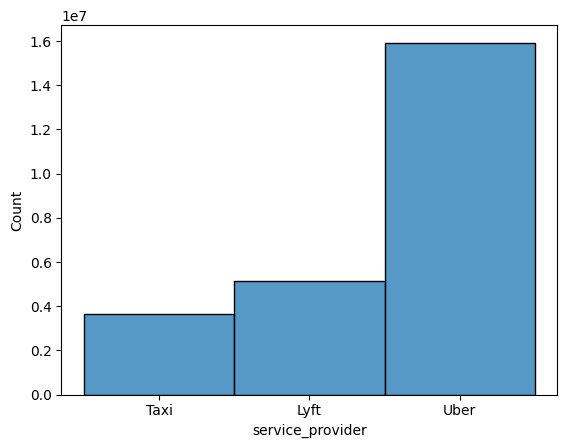

In [765]:
sns.histplot(x=trips_df['service_provider'])

<Axes: xlabel='transit_timestamp', ylabel='Count'>

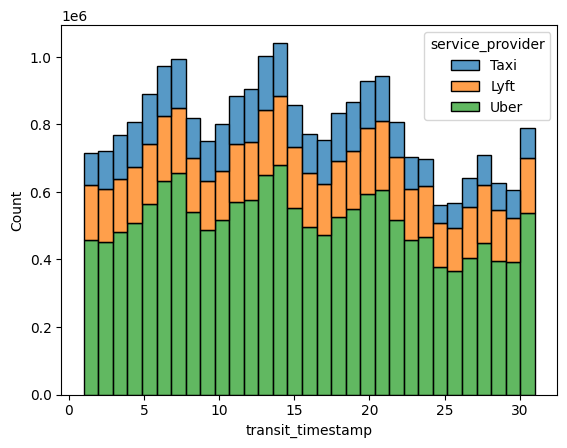

In [766]:
sns.histplot(data=trips_df, x=trips_df['transit_timestamp'].dt.day, bins=31, hue='service_provider', multiple='stack')

Text(0, 0.5, 'Demand')

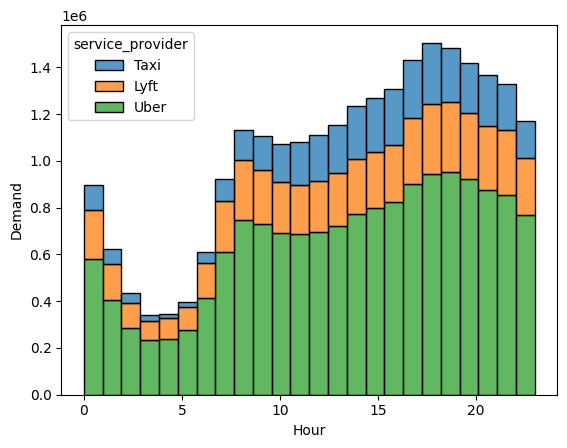

In [767]:
sns.histplot(data=trips_df, x=trips_df['transit_timestamp'].dt.hour, bins=24, hue='service_provider', multiple='stack')

plt.xlabel('Hour')
plt.ylabel('Demand')

<Axes: xlabel='Borough', ylabel='Count'>

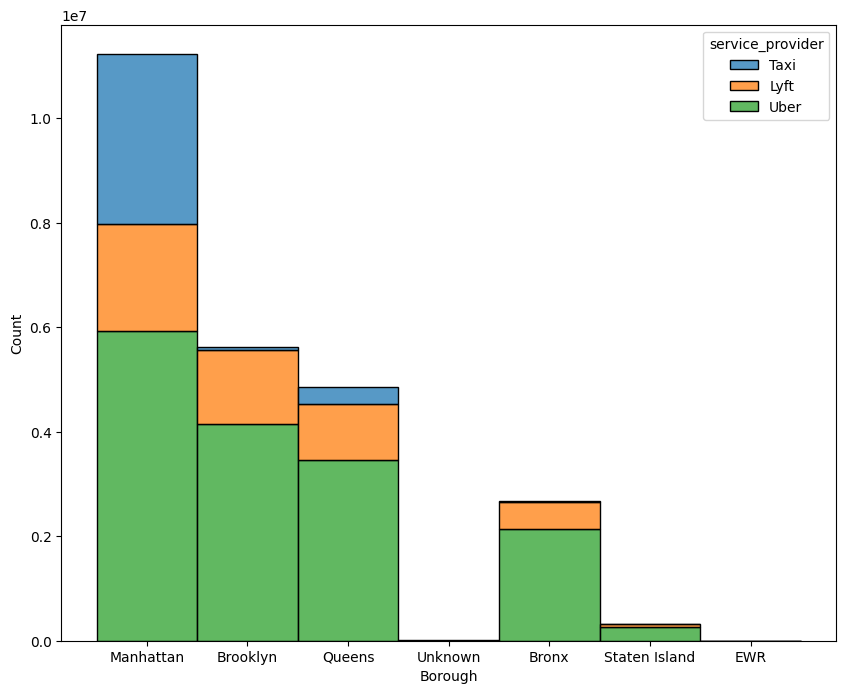

In [768]:
plt.figure(figsize=(10,8))
sns.histplot(data=trips_df, x='Borough', hue='service_provider', bins=200, multiple='stack')

### Permitted Events

<Axes: xlabel='event_borough', ylabel='Count'>

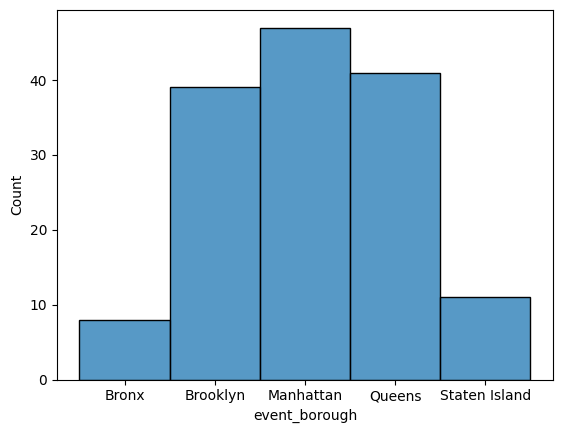

In [248]:
sns.histplot(data=event_counts_by_borough_df, x=event_counts_by_borough_df['event_borough'])

Text(0.5, 1.0, 'Number of Events in a Day (per Borough)')

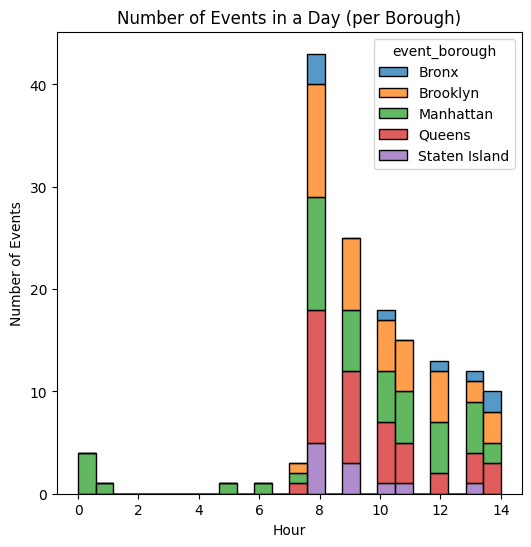

In [259]:
plt.figure(figsize=(6,6))
sns.histplot(data=event_counts_by_borough_df, x=event_counts_by_borough_df['start_date_time'].dt.hour, hue='event_borough', multiple='stack', bins=24)

plt.xlabel('Hour')
plt.ylabel('Number of Events')
plt.title('Number of Events in a Day (per Borough)')

Text(0.5, 1.0, 'Number of Events in a Week (per Borough)')

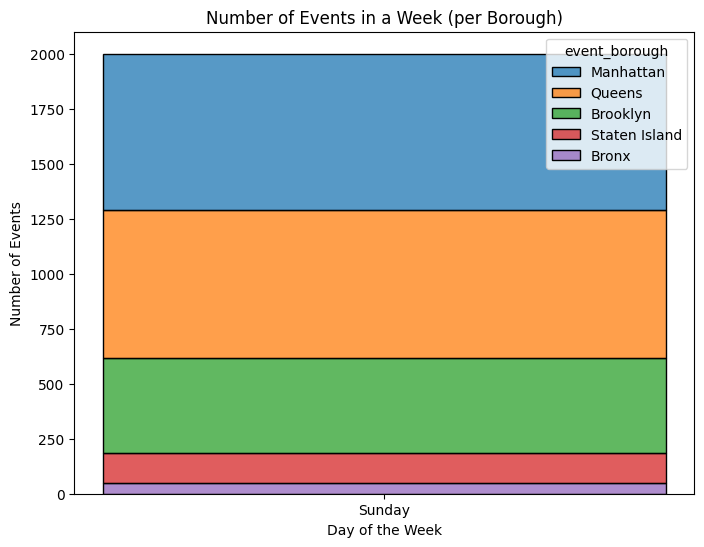

In [ ]:
plt.figure(figsize=(8,6))
sns.histplot(data=permitted_events_historical_df, x=permitted_events_historical_df['start_date_time'].dt.day_name(), hue='event_borough', multiple='stack')

plt.xlabel('Day of the Week')
plt.ylabel('Number of Events')
plt.title('Number of Events in a Week (per Borough)')

Text(0.5, 1.0, 'Number of Events in a Day (per Borough)')

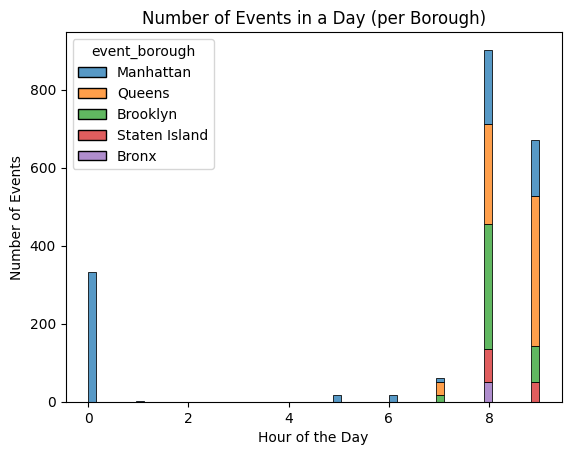

In [ ]:
sns.histplot(data=permitted_events_historical_df, x=permitted_events_historical_df['start_date_time'].dt.hour, hue='event_borough', multiple='stack')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Events')
plt.title('Number of Events in a Day (per Borough)')

## Buses & Subways

<Axes: xlabel='bus_route', ylabel='number_of_rides'>

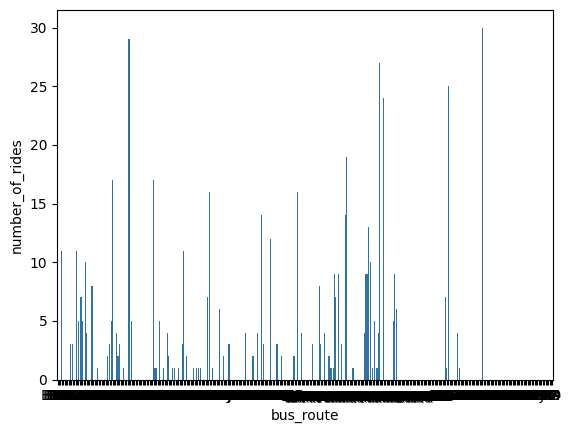

In [266]:
sns.barplot(data=bus_ridership_df, x='bus_route',y='number_of_rides')

# Creating Demand DataFrame

## Demand Trips DF

In [796]:
demand_trips_df = trips_df.copy()

#Aggregating data and calculating number of rides
demand_trips_df = demand_trips_df.groupby(['transit_timestamp','service_provider','Borough']).size().reset_index(name='demand')

In [797]:
demand_trips_df.sample(10)

,transit_timestamp,service_provider,Borough,demand
0,2024-12-01 00:00:00,Taxi,Manhattan,1
1,2024-12-01 00:00:01,Lyft,Brooklyn,1
2,2024-12-01 00:00:02,Taxi,Manhattan,1
3,2024-12-01 00:00:04,Taxi,Manhattan,2
4,2024-12-01 00:00:06,Taxi,Manhattan,1
5,2024-12-01 00:00:06,Taxi,Queens,1
6,2024-12-01 00:00:07,Taxi,Manhattan,1
7,2024-12-01 00:00:09,Taxi,Manhattan,2
8,2024-12-01 00:00:12,Taxi,Manhattan,2
9,2024-12-01 00:00:14,Taxi,Manhattan,1


## Demand DF

In [798]:
demand_df = demand_trips_df.merge(subway_ridership_df, how='outer', on=['transit_timestamp','service_provider','Borough','demand'])

In [804]:
demand_df.sample(10)

,transit_timestamp,service_provider,Borough,demand
10756633,2024-12-21 12:46:31,Taxi,Manhattan,1
14531019,2024-12-29 06:39:37,Uber,Queens,1
15504355,2024-12-31 10:14:51,Uber,Queens,1
5325866,2024-12-11 09:55:13,Lyft,Brooklyn,1
5882784,2024-12-12 10:55:14,Lyft,Brooklyn,1
3319124,2024-12-07 11:30:17,Uber,Brooklyn,2
11269798,2024-12-22 11:00:00,subway,Manhattan,68
9536431,2024-12-19 08:04:44,Uber,Brooklyn,5
1398575,2024-12-03 19:51:56,Uber,Manhattan,2
1053730,2024-12-03 06:00:00,subway,Brooklyn,1


# Exploring Demand DF

Text(0, 0.5, 'Demand')

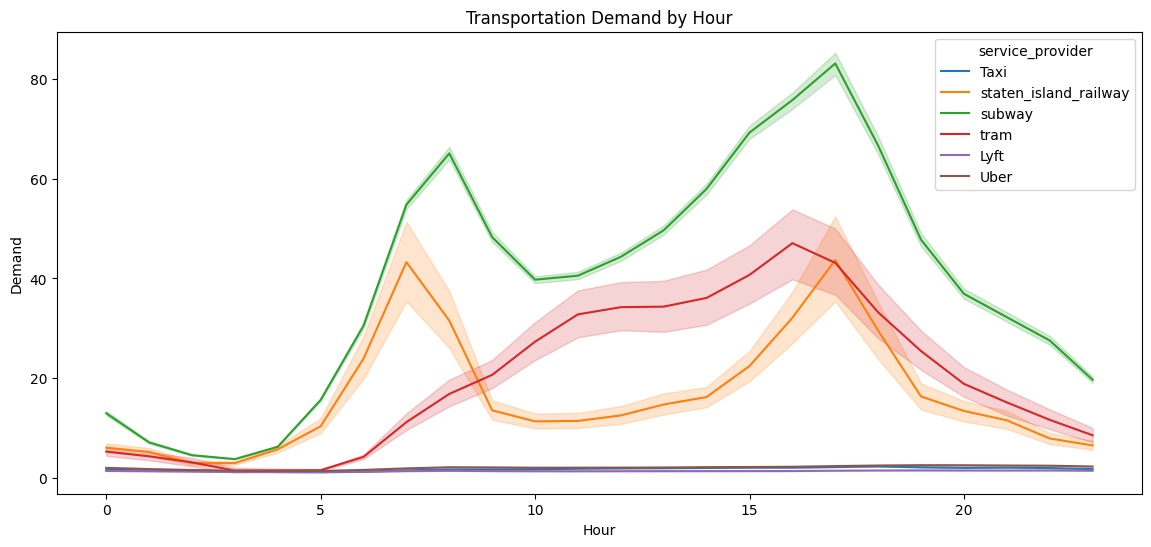

In [ ]:
plt.figure(figsize=(14,6))
sns.lineplot(data=demand_df,x=demand_df['transit_timestamp'].dt.hour,y='demand',hue='service_provider')

plt.title("Transportation Demand by Hour")
plt.xlabel("Hour")
plt.ylabel("Demand")

Text(0, 0.5, 'Demand')

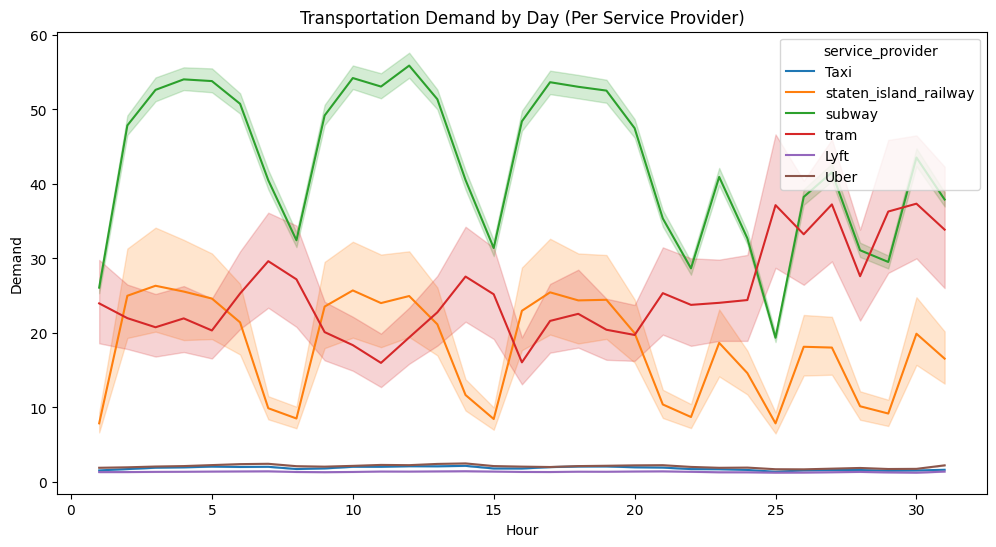

In [ ]:
plt.figure(figsize=(12,6))
sns.lineplot(data=demand_df,x=demand_df['transit_timestamp'].dt.day,y='demand',hue='service_provider')

plt.title("Transportation Demand by Day (Per Transport)")
plt.xlabel("Day")
plt.ylabel("Demand")
plt.legend("Transportation")

Text(0, 0.5, 'Demand')

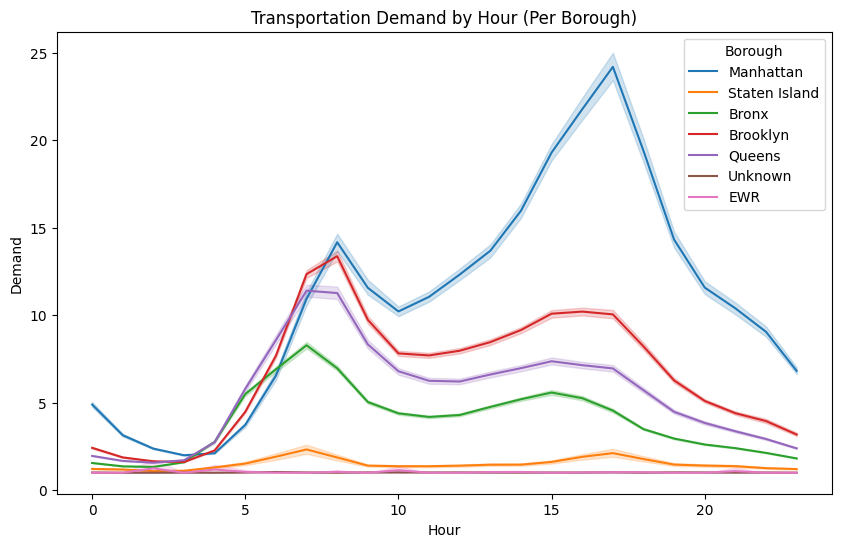

In [807]:
plt.figure(figsize=(10,6))
sns.lineplot(data=demand_df,x=demand_df['transit_timestamp'].dt.hour,y='demand',hue='Borough')

plt.title("Transportation Demand by Hour (Per Borough)")
plt.xlabel("Hour")
plt.ylabel("Demand")